In [34]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#for progress function bar
from tqdm import tqdm
import time

In [35]:
%run "C:\\Users\\adamj\\Documents\\Projekty_Python\\Quant_trading\\tickers.ipynb"
%run "C:\\Users\\adamj\\Documents\\Projekty_Python\\Quant_trading\\Plotting_backtesting.ipynb"

In [36]:
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [37]:
def generate_Breakout_signals(spx_data):
    # Resetting index to use the default integer index
    spx_data.reset_index(inplace=True)

    # Extracting relevant columns and calculating additional features
    prices = spx_data.drop(['Adj Close'], axis=1)
    prices['O-to-C'] = prices['Close'] - prices['Open']
    prices['OC-20D-Mean'] = prices['O-to-C'].rolling(20).mean()
    prices['OC-%-from-20D-Mean'] = 100 * (prices['O-to-C'] - prices['OC-20D-Mean']) / prices['OC-20D-Mean']
    prices['MaxOC_Prev10'] = prices['O-to-C'].rolling(10).max()
    prices['Volume-20D-Mean'] = prices['Volume'].rolling(20).mean()
    prices['Volume-%-from-20D-Mean'] = 100 * (prices['Volume'] - prices['Volume-20D-Mean']) / prices['Volume-20D-Mean']

    # Initializing a list to store signals
    signals = [None] * len(prices['Close'])

    # Defining breakout conditions
    # Conditions:
    # 1. Green candle,
    # 2. Candle's body is longest in the last 10 days,
    # 3. Breakout volume is 50% higher than the rolling 20-day average, and
    # 4. Breakout candle has a body that is 100% higher than the rolling 20-day average
    condition = (
        (prices['O-to-C'] >= 0.0) & 
        (prices['O-to-C'] == prices['MaxOC_Prev10']) & 
        (prices['OC-%-from-20D-Mean'] >= 100.0) & 
        (prices['Volume-%-from-20D-Mean'] >= 50.0)
    )

    # Loop through the dataframe and identify Buy signals based on the defined conditions
    for i in range(1, len(prices) - 10):
        if condition.iloc[i]:  # Check the condition for the specific index
            signals[i] = 'Buy'

    return signals

In [38]:
def download_stock_data(indices, start_date, end_date, interval):
    list_of_stock_data = []

    for i in range(len(indices)):
        symbol = indices[i]['yfticker']
        # Download stock data
        temp_data = yf.download(symbol, start=start_date, end=end_date, interval=interval, progress=False)
        if temp_data.empty :
            continue # Continue to the next iteration
        # Determine the Buy signals
        temp_data["ema"] = temp_data['Close'].ewm(span=200, adjust=False, min_periods=12).mean()
        temp_data['Signal'] = generate_Breakout_signals(temp_data)

        # Convert column names to lowercase
        temp_data.columns = [x.lower() for x in temp_data.columns]

        # Append the data to the list
        list_of_stock_data.append(temp_data)
            
    return list_of_stock_data

In [49]:
def simulate_trading(initial_money, capital, list_of_stock_data, spread=0.0017, leverage=1):
    num_shares = 0
    final_balance = 0
    num_trades = 0
    # Initialize equity column in the first stock data frame
    list_of_stock_data[0]['equity'] = [None] * len(list_of_stock_data[0]['close'])
    # Simulate buying and selling based on the generated signals
    for i in range(len(list_of_stock_data[0])):
        for j in range(len(list_of_stock_data)):
            divided = 1
            try:
                if list_of_stock_data[j]['signal'][i] == 'Buy':
                    num_shares = (initial_money / list_of_stock_data[j]['close'][i] * leverage) / divided
                    initial_money -= (num_shares * list_of_stock_data[j]['close'][i])
                    initial_money -= (spread * num_shares * list_of_stock_data[j]['open'][i])
                    num_trades += 1
                    # Selling open position with stoploss
                    stop_loss_iteration = 10
                    if (len(indices) - j) < 10:
                        stop_loss_iteration = len(indices) - j
                    for l in range(1, 10):
                        if list_of_stock_data[j]['close'][i + l] < list_of_stock_data[j]['open'][i]:
                            initial_money += (num_shares * list_of_stock_data[j]['close'][i + l])
                            break
                        elif l == 9:
                            initial_money += (num_shares * list_of_stock_data[j]['close'][i + 10])
                            break
            except  KeyError as e:
                continue
            list_of_stock_data[0]['equity'][i] = initial_money
    # Calculate the final balance based on the last stock price and remaining number of shares
    total_return = (initial_money - capital) / capital * 100
    # Return the final balance, profit/loss, total return, and total trades
    return {
        'final_balance': initial_money,
        'profit_loss': initial_money - capital,
        'total_return': total_return,
        'total_trades': num_trades
    }


In [40]:
#examples for list of stock data
list_of_stock_data = (make_dataframes_same_time(download_stock_data(return_random_symbols
                               ( df[df['GICS Sector'] == 'Industrials'], num_symbols=5),'2022-02-06','2023-12-21','1d')))
result = simulate_trading(initial_money=10000, capital=10000, list_of_stock_data=list_of_stock_data)
result

{'final_balance': 14171.411611641312,
 'profit_loss': 4171.4116116413115,
 'total_return': 41.714116116413116,
 'total_trades': 22}

In [44]:
#examples for specific stock
asset_list = []
asset_dict = {}  # Initialize a new dictionary for each asset
asset_dict['yfticker'] = 'xom'
asset_list.append(asset_dict)
list_of_stock_data =download_stock_data(asset_list ,'2023-01-06','2023-12-21','1h') 
result = simulate_trading(initial_money=10000, capital=10000, list_of_stock_data= list_of_stock_data  )
result

{'final_balance': 7385.264805349279,
 'profit_loss': -2614.7351946507206,
 'total_return': -26.147351946507207,
 'total_trades': 33}

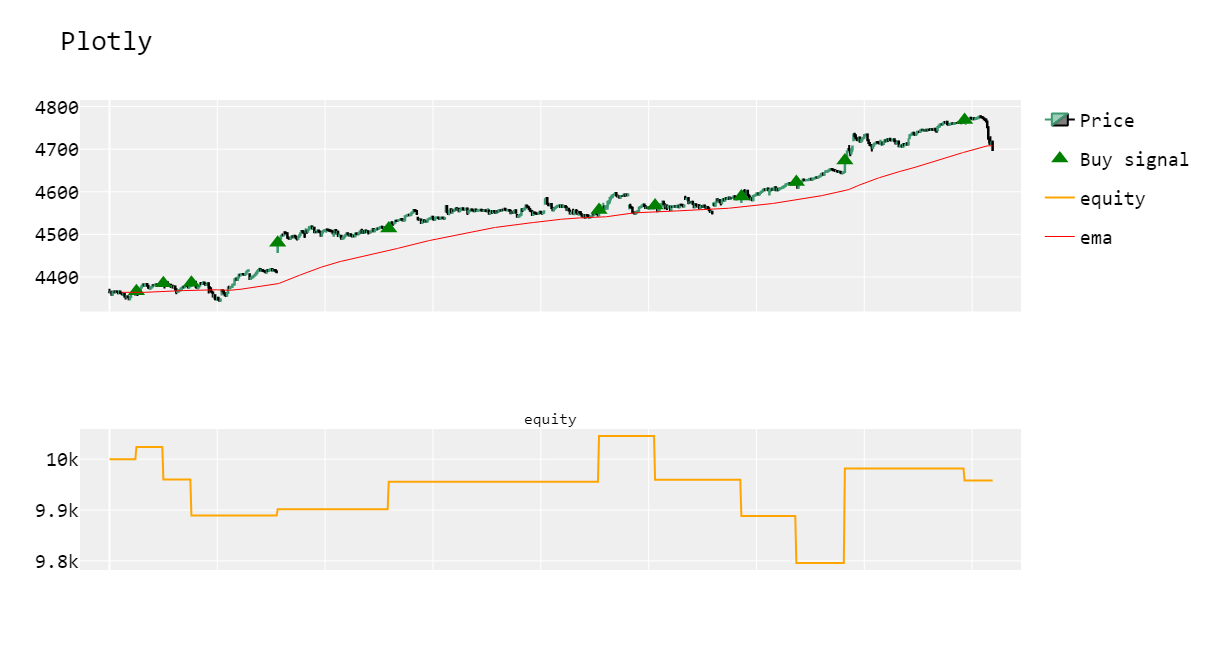

In [33]:
ploting_results_Breakout(list_of_stock_data[0])

In [50]:
def simulate_multiple_times(num_simulations,num_symbols,start, end, interval ):
    total_returns = []
    for _ in tqdm(range(num_simulations), desc="Processing", unit="iteration"):
        # Generate a list of random stock symbols and download stock data
        symbols = return_random_symbols(df, num_symbols=num_symbols)
        list_of_stock_data = make_dataframes_same_time(download_stock_data(symbols,start, end, interval))
        # Simulate trading
        result = simulate_trading(initial_money=10000, capital=10000, list_of_stock_data=list_of_stock_data)
        # Append the total return to the list
        total_returns.append(result['total_return'])
    # Calculate and return the average return
    average_return = sum(total_returns) / num_simulations
    return average_return

In [51]:
tradelog = []
# Example usage:
for i in range(0,10):
    average_return_result = simulate_multiple_times(num_simulations=10,num_symbols=10 ,start='2023-11-06',end= '2023-12-21',interval= '30m')
    print(f"Average Return over simulations: {average_return_result:.2f}%")
    tradelog.append({'average_return_result':average_return_result })

Processing: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/iteration]


Average Return over simulations: 26.08%


Processing:  60%|██████████████████████████████████████▍                         | 6/10 [00:14<00:09,  2.41s/iteration]
1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (15m 2023-11-06 -> 2023-12-21)')
Processing: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.38s/iteration]


Average Return over simulations: 13.32%


Processing:  80%|███████████████████████████████████████████████████▏            | 8/10 [00:19<00:05,  2.55s/iteration]
1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
Processing: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.64s/iteration]


Average Return over simulations: 20.13%


Processing: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/iteration]


Average Return over simulations: 24.14%


Processing:  10%|██████▍                                                         | 1/10 [00:02<00:21,  2.39s/iteration]
1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (15m 2023-11-06 -> 2023-12-21)')
Processing: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/iteration]


Average Return over simulations: 33.16%


Processing: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.31s/iteration]


Average Return over simulations: 17.81%


Processing: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.41s/iteration]


Average Return over simulations: 24.00%


Processing: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/iteration]


Average Return over simulations: 9.50%


Processing: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.39s/iteration]


Average Return over simulations: 17.88%


Processing: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.35s/iteration]

Average Return over simulations: 29.30%


In [17]:
# num_simulations=50,num_symbols=5 12.15    2 years   '2022-01-06', '2023-12-21', '1h' divided 1
# num_simulations=50,num_symbols=10 33.78%    2 years  '2022-01-06', '2023-12-21', '1h' divided 1
# num_simulations=50,num_symbols=10 29.40%    2 years  '2022-01-06', '2023-12-21', '1h' divided 1
# num_simulations=50,num_symbols=10 50.31%   2 years  '2022-01-06', '2023-12-21', '1h' divided 1
# num_simulations=50,num_symbols=10 22.32%  half year  '2023-06-06', '2023-12-21', '1h' divided 1
# num_simulations=50,num_symbols=10 33.06%  half year  '2023-06-06', '2023-12-21', '1h' divided 1
# num_simulations=50,num_symbols=10 28.64%  half year  '2023-06-06', '2023-12-21', '1h' divided 1

# num_simulations=50,num_symbols=5 13.92%  half year  '2023-06-06', '2023-12-21', '1h'
# num_simulations=50,num_symbols=5 10.47%  half year  '2023-06-06', '2023-12-21', '1h'

# num_simulations=10,num_symbols=15 4.50%    '2023-06-06', '2023-12-21', '1h' divided 10
# num_simulations=10,num_symbols=15 2.94%   '2023-06-06', '2023-12-21', '1h' divided 10
# num_simulations=10,num_symbols=15 3.37%    '2023-06-06', '2023-12-21', '1h' divided 10
# num_simulations=10,num_symbols=15 3.21%    '2023-06-06', '2023-12-21', '1h' divided 10
# num_simulations=10,num_symbols=15 4.12%    '2023-06-06', '2023-12-21', '1h' divided 10

# num_simulations=10,num_symbols=10  '2023-06-06', '2023-12-21', '1h' divided 10 leverage 2 
'''
  'average_return_result': 4.043863580464484},
  'average_return_result': 2.191567695877391},
  'average_return_result': 4.129315656046248},
  'average_return_result': 3.502545952839635},
  'average_return_result': 3.452537209690759},
  'average_return_result': 3.9012952486111536},
  'average_return_result': 7.208922721568581},
  'average_return_result': 2.590069661118432},
  'average_return_result': 5.132842119081065},
  'average_return_result': 5.0440514572160655}]
'''
# num_simulations=10,num_symbols=10  '2023-01-06', '2023-12-21', '1h' divided 10 leverage 2 
'''
  'average_return_result': 8.206676155638387},
  'average_return_result': 5.7515463723856985},
  'average_return_result': 6.05737413520775},
  'average_return_result': 5.734789060769237},
  'average_return_result': 3.980010803200048},
  'average_return_result': 9.576529708333032},
  'average_return_result': 6.587304784593464},
  'average_return_result': 5.133507534398095},
  'average_return_result': 5.899494666432799},
  'average_return_result': 6.391419742278825
'''

In [ ]:
#tradelog = []
#tradelog.append({'date': datetime.now(), 'average_return_result':average_return_result })

In [52]:
tradelog 

[{'average_return_result': 26.07655475344482},
 {'average_return_result': 13.32473123184198},
 {'average_return_result': 20.132913739190542},
 {'average_return_result': 24.140101862804407},
 {'average_return_result': 33.164535724122544},
 {'average_return_result': 17.81178448790221},
 {'average_return_result': 23.9973717759201},
 {'average_return_result': 9.496286064321927},
 {'average_return_result': 17.87717938478208},
 {'average_return_result': 29.304509259421877}]

In [53]:
values = [item['average_return_result'] for item in tradelog ]
# Calculate the average
average_result = sum(values) / len(values)
print(f'The average is: {average_result}')

The average is: 21.53259682837525
